### (Inspired from https://towardsdatascience.com/anomaly-detection-in-time-series-sensor-data-86fd52e62538)

In [17]:
import sys
from os import listdir
from os.path import isfile, join
from datetime import  timezone

from tqdm.notebook import tqdm
import mne
import pandas as pd
import matplotlib.pyplot as plt

from pyapnea.oscar.oscar_loader import load_session
from pyapnea.oscar.oscar_getter import event_data_to_dataframe
from pyapnea.oscar.oscar_constants import CHANNELS, ChannelID

In [18]:
# all files
data_path_cpap1 = '../data/raw/ResMed_23192565579/Events'
list_files = [{'label': f, 'value': f, 'fullpath': join(data_path_cpap1, f)} for f in listdir(data_path_cpap1) if isfile(join(data_path_cpap1, f))]
data_path_cpap2= '../data/raw/ResMed_23221085377/Events'
list_files.extend([{'label': f, 'value': f, 'fullpath': join(data_path_cpap2, f)} for f in listdir(data_path_cpap2) if isfile(join(data_path_cpap2, f))])

In [19]:
sfreq = 25

In [20]:
filename_to_load = '../data/raw/ResMed_23192565579/Events/62202198.001'
oscar_session_data = load_session(filename_to_load)
df = event_data_to_dataframe(oscar_session_data, [ChannelID.CPAP_FlowRate.value, ChannelID.CPAP_ClearAirway.value, ChannelID.CPAP_Obstructive.value])
df.set_index('time_utc', inplace=True)
df

,FlowRate,ClearAirway,Obstructive
time_utc,,,
2022-03-03 02:02:51+00:00,37.560001,NaN,NaN
2022-03-03 02:02:51.040000+00:00,37.920002,NaN,NaN
2022-03-03 02:02:51.080000+00:00,38.880002,NaN,NaN
2022-03-03 02:02:51.120000+00:00,38.760002,NaN,NaN
2022-03-03 02:02:51.160000+00:00,37.320001,NaN,NaN
...,...,...,...
2022-03-03 10:03:50.800000+00:00,-19.920001,NaN,NaN
2022-03-03 10:03:50.840000+00:00,-19.320001,NaN,NaN
2022-03-03 10:03:50.880000+00:00,-18.360001,NaN,NaN


In [21]:
# reorganize dataframe to seaborn imput format

dfc = df[['FlowRate']]
# dfm = dfc.melt('time_utc', var_name='cols', value_name='vals')
# dfm.sort_values(by=['time_utc'], inplace=True, ignore_index=True)
# dfm_annotation = dfm[(~pd.isnull(dfm['vals']) & ((dfm['cols']=='Obstructive') | (dfm['cols']=='ClearAirway')))]
# display(dfm_annotation)
dfm_annotation=df[~df['Obstructive'].isna() | ~df['ClearAirway'].isna()]
dfm_annotation=dfm_annotation[['Obstructive', 'ClearAirway']]
dfm_annotation

,Obstructive,ClearAirway
time_utc,,
2022-03-03 03:33:46+00:00,NaN,17.0
2022-03-03 03:42:09+00:00,18.0,NaN
2022-03-03 03:58:59+00:00,NaN,12.0
2022-03-03 04:56:32+00:00,NaN,18.0
2022-03-03 05:07:13+00:00,NaN,18.0
2022-03-03 06:08:35+00:00,NaN,10.0
2022-03-03 06:51:51+00:00,NaN,10.0
2022-03-03 07:14:26+00:00,NaN,23.0
2022-03-03 07:16:13+00:00,NaN,14.0


## Exploratory Data Analysis (EDA)

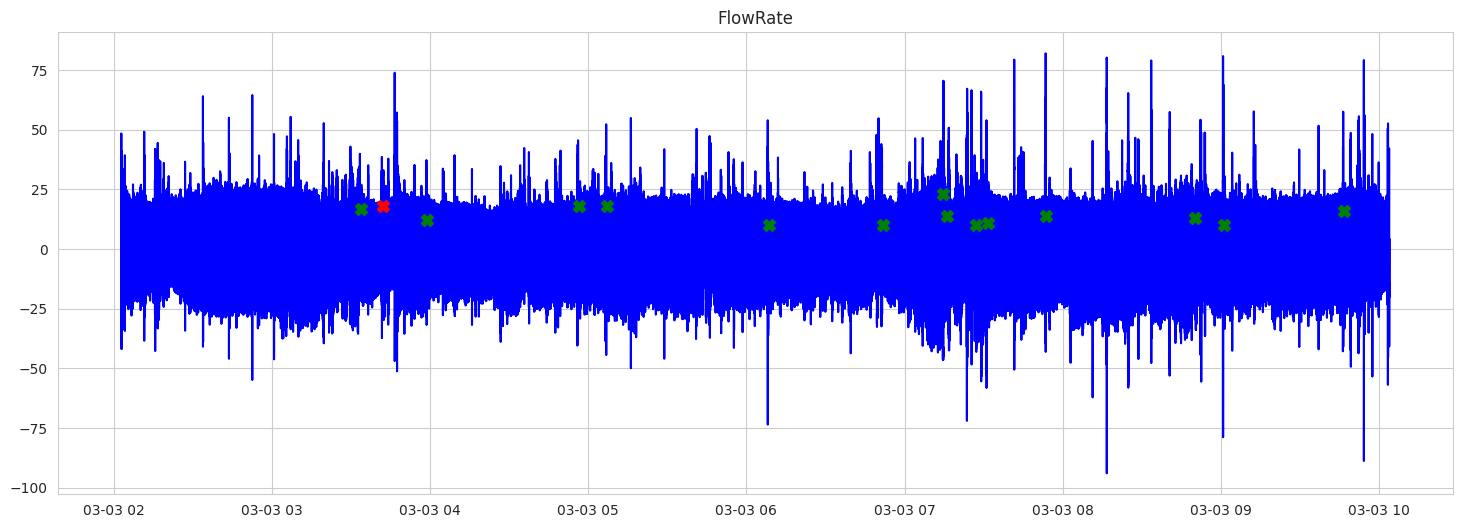

In [22]:

_ = plt.figure(figsize=(18,6))
_ = plt.plot(dfc['FlowRate'], color='blue')
_ = plt.plot(dfm_annotation[~dfm_annotation['Obstructive'].isna()], linestyle='none', marker='X', color='red', markersize=8)
_ = plt.plot(dfm_annotation[~dfm_annotation['ClearAirway'].isna()], linestyle='none', marker='X', color='green', markersize=8)
_ = plt.title('FlowRate')
plt.show()

In [23]:
rollmean = dfc.resample(rule='T').mean()
rollstd = dfc.resample(rule='T').std()

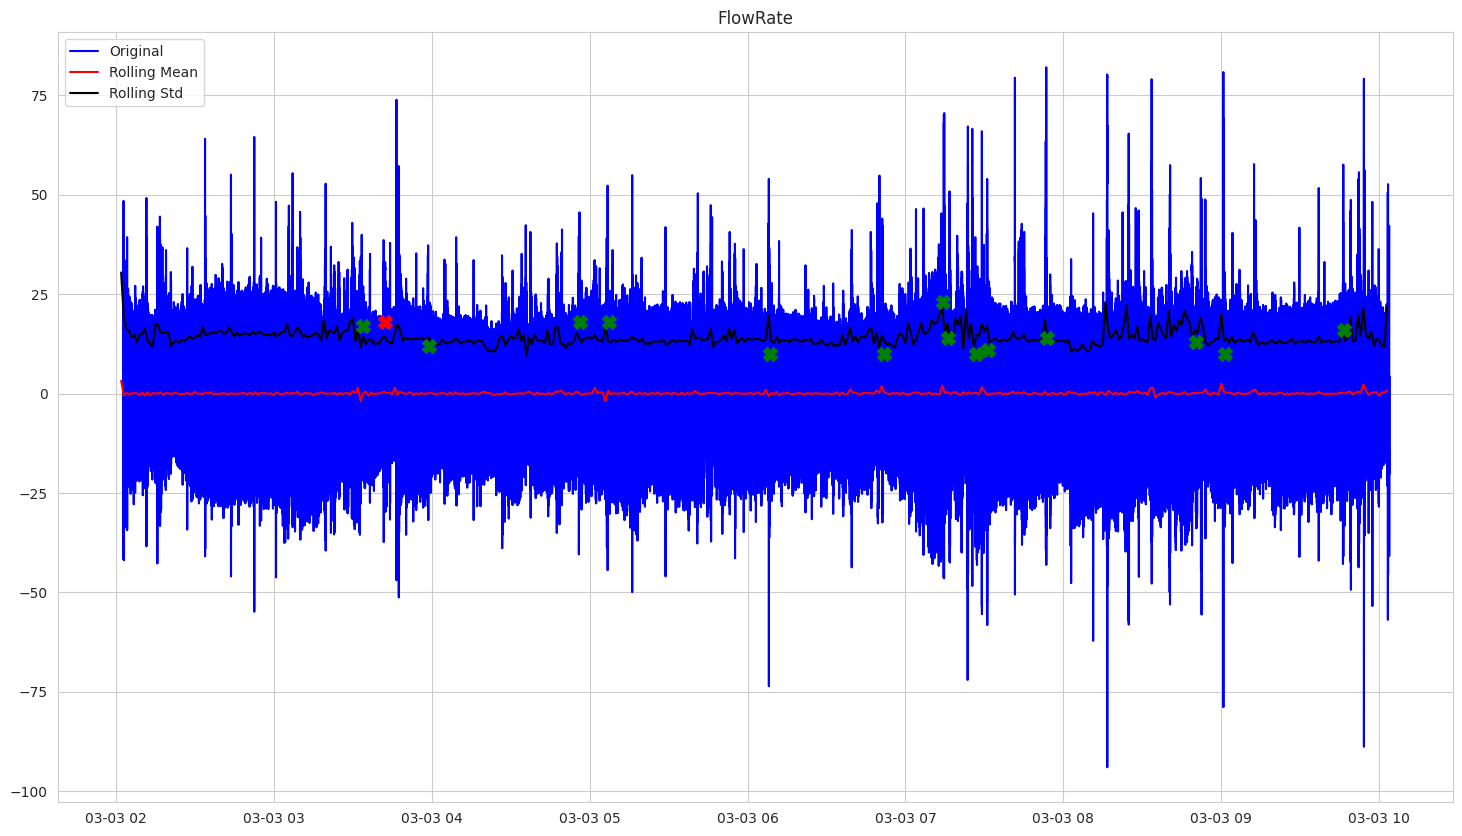

In [24]:
_ = plt.figure(figsize=(18,10))
_ = plt.plot(dfc['FlowRate'], color='blue', label='Original')
_ = plt.plot(rollmean['FlowRate'], color='red', label='Rolling Mean')
_ = plt.plot(rollstd['FlowRate'], color='black', label='Rolling Std' )
_ = plt.plot(dfm_annotation[~dfm_annotation['Obstructive'].isna()], linestyle='none', marker='X', color='red', markersize=10)
_ = plt.plot(dfm_annotation[~dfm_annotation['ClearAirway'].isna()], linestyle='none', marker='X', color='green', markersize=10)
_ = plt.legend(loc='best')
_ = plt.title('FlowRate')
plt.show()